In [2]:
import os
base_dir = 'C:/Users/IVPL-D14/Desktop/cropped_data/total'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
#validation_dir = 'C:/Users/IVPL-D14/Desktop/cropped_data/bats_knives/validation'
test_dir = os.path.join(base_dir, 'test')
#test_dir = 'C:/Users/IVPL-D14/Desktop/cropped_data/bats_knives/test'

train_knife_dir = os.path.join(train_dir, 'knife')
train_bat_dir = os.path.join(train_dir, 'bat')

train_size, validation_size, test_size = 200, 100, 100


In [3]:
print(test_dir)

C:/Users/IVPL-D14/Desktop/cropped_data/total\test


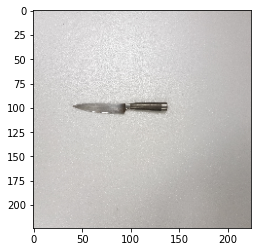

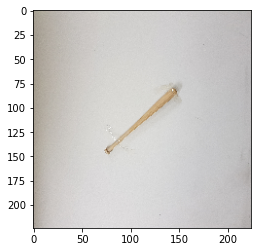

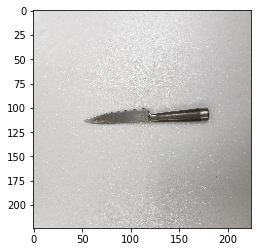

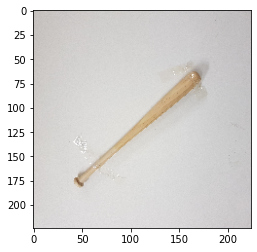

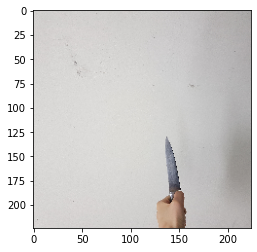

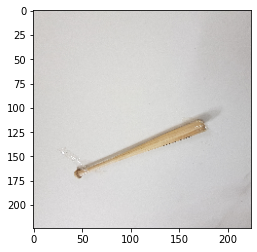

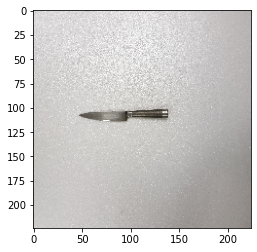

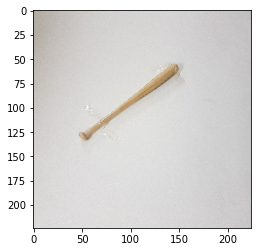

In [7]:
# Show pictures
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,4):
    show_pictures(train_knife_dir)
    show_pictures(train_bat_dir)

In [5]:

img_width, img_height = 224, 224  # Default input size for VGG16
# Instantiate convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3)) 
# 3 = number of channels in RGB pictures


In [8]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  
    # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [10]:
# Debug
print(train_features)
print(train_labels)

[[[[0.12984252 0.         0.         ... 0.         0.74749529
    0.        ]
   [0.08635678 0.         0.         ... 0.         0.75262988
    0.        ]
   [0.03926447 0.         0.         ... 0.         0.75622553
    0.        ]
   ...
   [0.         0.         0.04964089 ... 0.         0.58227783
    0.        ]
   [1.08002234 0.         0.10395548 ... 0.         0.40924889
    0.        ]
   [1.26580441 0.         0.         ... 0.         0.79630238
    0.        ]]

  [[0.03382187 0.         0.         ... 0.         0.59911841
    0.        ]
   [0.03839953 0.         0.         ... 0.         0.59440196
    0.        ]
   [0.0609028  0.         0.         ... 0.         0.63089788
    0.        ]
   ...
   [0.29734969 0.         0.         ... 0.         0.42961568
    0.        ]
   [1.29622102 0.         0.         ... 0.         0.
    0.        ]
   [1.21160424 0.         0.         ... 0.         0.52369666
    0.        ]]

  [[0.         0.         0.         ... 0

In [11]:
# Define model

from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [13]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
7/7 [==============================] - 0s 25ms/step - loss: 1.2222 - acc: 0.6750 - val_loss: 0.1791 - val_acc: 0.9300
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.1697 - acc: 0.9200 - val_loss: 0.1055 - val_acc: 0.9400
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0504 - acc: 0.9950 - val_loss: 0.1697 - val_acc: 0.9300
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0414 - acc: 0.9850 - val_loss: 0.1447 - val_acc: 0.9300
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.0582 - val_acc: 0.9800
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0140 - acc: 0.9950 - val_loss: 0.1372 - val_acc: 0.9300
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.1254 - val_acc: 0.9300
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0047 - acc: 1.0000 - va

Epoch 63/100
7/7 [==============================] - 0s 8ms/step - loss: 8.0372e-04 - acc: 1.0000 - val_loss: 0.1473 - val_acc: 0.9300
Epoch 64/100
7/7 [==============================] - 0s 9ms/step - loss: 2.7499e-04 - acc: 1.0000 - val_loss: 0.1239 - val_acc: 0.9300
Epoch 65/100
7/7 [==============================] - 0s 9ms/step - loss: 4.9242e-04 - acc: 1.0000 - val_loss: 0.1017 - val_acc: 0.9400
Epoch 66/100
7/7 [==============================] - 0s 9ms/step - loss: 1.9423e-04 - acc: 1.0000 - val_loss: 0.0858 - val_acc: 0.9400
Epoch 67/100
7/7 [==============================] - 0s 8ms/step - loss: 2.6955e-04 - acc: 1.0000 - val_loss: 0.0804 - val_acc: 0.9500
Epoch 68/100
7/7 [==============================] - 0s 8ms/step - loss: 1.8305e-04 - acc: 1.0000 - val_loss: 0.0865 - val_acc: 0.9400
Epoch 69/100
7/7 [==============================] - 0s 9ms/step - loss: 5.1843e-04 - acc: 1.0000 - val_loss: 0.0890 - val_acc: 0.9400
Epoch 70/100
7/7 [==============================] - 0s 9ms/ste

In [14]:
# Save model
model.save('knife_bat_0225.h5')

## model evaluation

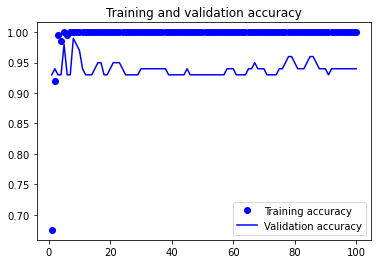

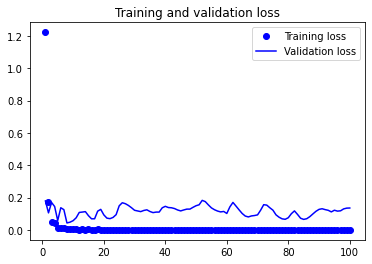

In [15]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
test_knife_dir = os.path.join(test_dir, 'knife')
test_bat_dir = os.path.join(test_dir, 'bat')

# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_bat_dir, test_knife_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('bat')
        else:
            print('knife')

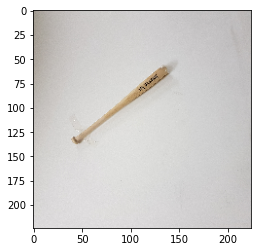

bat


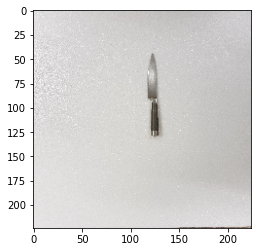

knife


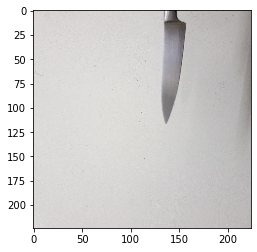

knife


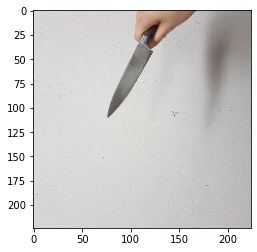

knife


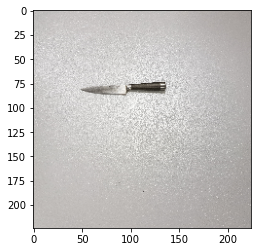

knife


In [23]:
# Visualize predictions
visualize_predictions(model, 5)